In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from fastai.text.all import *
import glob

## 1. Train the Laugange Mode with the oversampling data

In [2]:
# get the word model vocabulary
def get_questions(path):
    return df_words['text'].tolist()

word_path = 'words_oversampled.csv'
df_words = pd.read_csv(word_path)

dls_lm = DataBlock(
    blocks = TextBlock.from_df(df_words, is_lm=True),
    get_items=get_questions,
    splitter=RandomSplitter(0.2)
).dataloaders(word_path, bs=120)

# We get 4400 vocabulary
lm_vocab = dls_lm.vocab
len(lm_vocab), lm_vocab[-20:]

(4400,
 ['wan',
  'utile',
  'fill',
  'yow',
  'agaist',
  'disguise',
  'globlal',
  'jods',
  'somone',
  'requirement',
  'soffer',
  'wheter',
  'backside',
  'yuo',
  'xxfake',
  'xxfake',
  'xxfake',
  'xxfake',
  'xxfake',
  'xxfake'])

In [3]:
df_words.tail()

,text
14484,whant are your best tips for entertaining youthful kids during the stay tt nurce hme orders in thhe tiime of the covid crisis
14485,hwat be your best tip fpr entertaining young kides druing the stay at habitation orders inj rthe time of the covid crisis
14486,what are your besto peak foi entertaining immature kids during the stays at home ordet in the time ofo the covid crises
14487,what are yoour in effect tipps for entertaining Yong kids during THER arrest at come orders jn the clip of the covid crisis
14488,what are yoyur justo tips for entertain young shaver during there stay at nursey home orders In the time of tho covid crisis


In [4]:
df_covid_vocabulary = pd.DataFrame(lm_vocab, columns=['vocab'])
df_covid_vocabulary.to_csv('covid_lm_vocab.csv', index=False)
df_covid_vocabulary

,vocab
0,xxunk
1,xxpad
2,xxbos
3,xxeos
4,xxfld
...,...
4395,xxfake
4396,xxfake
4397,xxfake
4398,xxfake


In [5]:
lm_learner = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, 
    metrics=[accuracy, Perplexity()]).to_fp16()

lm_learner.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,6.769078,5.467094,0.162043,236.771118,00:05


SuggestedLRs(valley=tensor(0.0021))

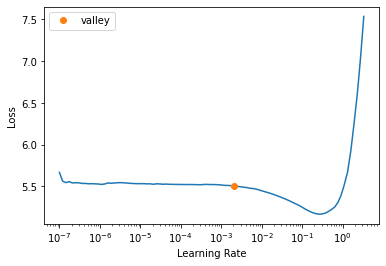

In [6]:
lm_learner.lr_find()

In [7]:
lm_learner.freeze_to(-2)
lm_learner.fit_one_cycle(1, slice(2.1e-3/(2.6**4),2.1e-3))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.276217,5.072005,0.208426,159.493835,00:05


SuggestedLRs(valley=tensor(0.0025))

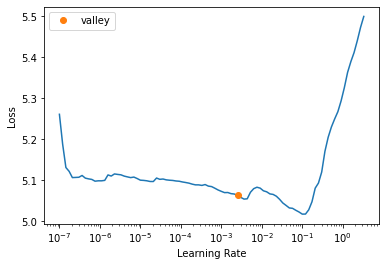

In [8]:
lm_learner.lr_find()

In [9]:
lm_learner.freeze_to(-3)
lm_learner.fit_one_cycle(1, slice(2.5e-3/(2.6**4),2.5e-3))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.007902,4.876656,0.235064,131.191177,00:05


SuggestedLRs(valley=tensor(0.0008))

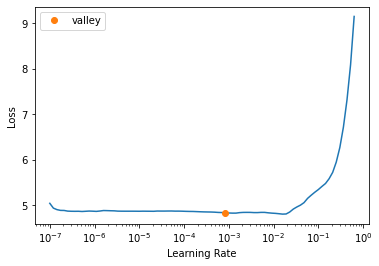

In [10]:
lm_learner.lr_find()

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.822403,4.780893,0.248403,119.210739,00:05
1,4.729030,4.619288,0.259294,101.421791,00:05
2,4.647036,4.657135,0.257685,105.333870,00:05
3,4.496842,4.325147,0.294410,75.576599,00:05
4,4.325600,4.221052,0.307558,68.105103,00:05
5,4.166139,4.158492,0.315585,63.974949,00:05
6,4.014201,4.114353,0.321453,61.212578,00:05
7,3.881903,4.082459,0.325943,59.291084,00:05
8,3.773374,4.076517,0.327425,58.939804,00:05
9,3.690667,4.076793,0.327483,58.956104,00:05


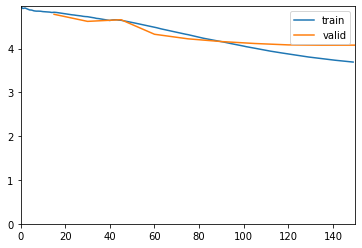

In [12]:
lm_learner.unfreeze()
lm_learner.fit_one_cycle(10, 8e-4,cbs=[ShowGraphCallback()])

SuggestedLRs(valley=tensor(0.0002))

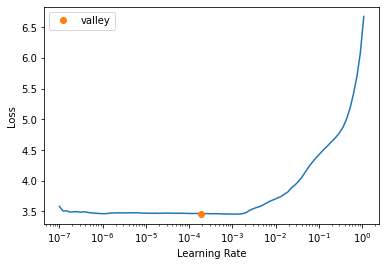

In [13]:
lm_learner.lr_find()

#### As we can see that the validation and train started deverge, it's time to stop training

In [14]:
lm_learner.save('lm_10epoch-os')

Path('models/lm_10epoch-os.pth')

In [15]:
lm_learner.save_encoder('lm_10epoch-os-encoder')

In [16]:
lm_learner.export('lm_10epoch-os.pkl')

Now I got my language mode trained and saved the encoder for later use when training the text classification mode.

In [18]:
TEXT = "where can I travel"
N_WORDS = 40
N_SENTENCES = 2
preds = [lm_learner.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]
print("\n".join(preds))

where can i travel if comm my child gets sick with covid es is nt hand sanitizer live covid more likely to be covid what is the beginning of the covid pandemic how badly has the covid virus alter its
where can i travel far are covid cases drinking o low hand sanitizer what are my tips for staying alive in an area where covid is contagious what has happened to the covid wy covid deaths wy are covid


In [24]:
# Save the vocabulary from the language mode for text classification model
df_lm_vocab = pd.DataFrame(lm_vocab)
# df_lm_vocab.to_csv('assets/lm_vocab.csv', index=False, header=None)

## 2. Training the Text Classification Model

**Make sure the ds files loaded in the sequence that my model training process expects**

So what does this mean?
Initially, I have my file named like this:

1. '/media/winstonfan/Workspace/MyDoc/Interviews/DigitalVictoria/temp/covidfaqbot/datascience/notebooks/ds_100.csv',
2. '/media/winstonfan/Workspace/MyDoc/Interviews/DigitalVictoria/temp/covidfaqbot/datascience/notebooks/ds_130.csv',
3. '/media/winstonfan/Workspace/MyDoc/Interviews/DigitalVictoria/temp/covidfaqbot/datascience/notebooks/ds_165.csv',
4. '/media/winstonfan/Workspace/MyDoc/Interviews/DigitalVictoria/temp/covidfaqbot/datascience/notebooks/ds_255.csv',
5. '/media/winstonfan/Workspace/MyDoc/Interviews/DigitalVictoria/temp/covidfaqbot/datascience/notebooks/ds_30.csv',
6. '/media/winstonfan/Workspace/MyDoc/Interviews/DigitalVictoria/temp/covidfaqbot/datascience/notebooks/ds_65.csv',
7. '/media/winstonfan/Workspace/MyDoc/Interviews/DigitalVictoria/temp/covidfaqbot/datascience/notebooks/ds_81.csv'
 
And when we load the files using the `glob.glob()` method, it loads the model for categories which have more than 100 but less then 130 number of sampling data first, so the `all_file[0]` is actually the data set for categories 100-130, rather than the data set which has the categories which have less then 30 number of sampleing data!!!!

In [2]:
path = r'/media/winstonfan/Workspace/MyDoc/Interviews/DigitalVictoria/temp/covidfaqbot/datascience/notebooks' # use your path
all_files = glob.glob(path + "/ds_*.csv")

# check na
for fname in all_files:    
    df_labels = pd.read_csv(fname)

    null_columns=df_labels.columns[df_labels.isnull().any()]
    print(df_labels[null_columns].isnull().sum())

Series([], dtype: float64)
Series([], dtype: float64)
Series([], dtype: float64)
Series([], dtype: float64)
Series([], dtype: float64)
Series([], dtype: float64)
Series([], dtype: float64)


In [3]:
all_files

['/media/winstonfan/Workspace/MyDoc/Interviews/DigitalVictoria/temp/covidfaqbot/datascience/notebooks/ds_0_30.csv',
 '/media/winstonfan/Workspace/MyDoc/Interviews/DigitalVictoria/temp/covidfaqbot/datascience/notebooks/ds_1_65.csv',
 '/media/winstonfan/Workspace/MyDoc/Interviews/DigitalVictoria/temp/covidfaqbot/datascience/notebooks/ds_2_81.csv',
 '/media/winstonfan/Workspace/MyDoc/Interviews/DigitalVictoria/temp/covidfaqbot/datascience/notebooks/ds_3_100.csv',
 '/media/winstonfan/Workspace/MyDoc/Interviews/DigitalVictoria/temp/covidfaqbot/datascience/notebooks/ds_4_130.csv',
 '/media/winstonfan/Workspace/MyDoc/Interviews/DigitalVictoria/temp/covidfaqbot/datascience/notebooks/ds_5_165.csv',
 '/media/winstonfan/Workspace/MyDoc/Interviews/DigitalVictoria/temp/covidfaqbot/datascience/notebooks/ds_6_255.csv']

In [4]:
df_lm_vocab = pd.read_csv('assets/lm_vocab.csv', header=None)
df_lm_vocab.columns = ['word']
lm_vocab = df_lm_vocab['word'].tolist()
lm_vocab

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxrep',
 'xxwrep',
 'xxup',
 'xxmaj',
 'covid',
 'the',
 'to',
 'is',
 'what',
 'of',
 'how',
 'i',
 'a',
 'be',
 'for',
 'in',
 'are',
 'can',
 'will',
 'do',
 'it',
 'and',
 'from',
 'you',
 'that',
 'should',
 'pandemic',
 'if',
 'have',
 'why',
 '[',
 'on',
 'with',
 'virus',
 'get',
 'or',
 "'s",
 'china',
 'does',
 'there',
 'at',
 'who',
 'when',
 'my',
 'we',
 'people',
 'by',
 'was',
 'which',
 'as',
 'during',
 'an',
 'wherefore',
 'has',
 'did',
 's',
 'go',
 'than',
 'trump',
 'outbreak',
 'make',
 'world',
 'after',
 'kill',
 'us',
 'take',
 'virtus',
 'information',
 'vaccine',
 'nt',
 'spread',
 'come',
 'long',
 'not',
 ')',
 'symptoms',
 'live',
 'technology',
 'more',
 'your',
 'test',
 'so',
 'any',
 '(',
 'out',
 'lockdown',
 '.',
 'about',
 'where',
 'due',
 'health',
 'being',
 'risk',
 'haw',
 'against',
 'they',
 'o',
 'been',
 'could',
 'flu',
 'would',
 'between',
 'de',
 'way',
 'sanitizer',
 'safe',
 'e',
 

In [5]:
def getTextLabels(arg):
    df = pd.read_csv(arg)
    return df[['text', 'cid']]

textBlock = (TextBlock.from_df(text_cols = ['text'], vocab=lm_vocab),CategoryBlock)

dataloaders = []

# Construct all dataloaders
for ds_path in all_files:
    
    df_labels = pd.read_csv(ds_path)
    
    dls_clas = DataBlock(
        blocks=textBlock,
        get_x = ColReader(cols='text'),
        get_y = ColReader(cols = "cid"),
        get_items= getTextLabels,
        splitter = TrainTestSplitter(test_size = 0.2, random_state = 21, stratify=df_labels["cid"])
    ).dataloaders(ds_path, bs=120)
    
    dataloaders.append(dls_clas)

/home/winstonfan/anaconda3/envs/fastai24/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


/home/winstonfan/anaconda3/envs/fastai24/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


/home/winstonfan/anaconda3/envs/fastai24/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


/home/winstonfan/anaconda3/envs/fastai24/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


/home/winstonfan/anaconda3/envs/fastai24/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


/home/winstonfan/anaconda3/envs/fastai24/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


/home/winstonfan/anaconda3/envs/fastai24/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


For precaution, we just show at least 2 records from each dataset to check whether the dataloaders are in the right sequence

In [6]:
for dls in dataloaders:
    dls.valid.show_batch(max_n=2)

,text,category
0,xxbos wherefore are all patietns that die xxunk covid benig xxunk at covid related death yet though covid might not habe xxmaj iive the cause,85
1,xxbos is it potential ton develop a vaccine for covid ir it turn uo that sill survivors do nt develop resistance to this desease,82


,text,category
0,xxbos testament i be abble wo get under one ' s skin xxrep 3 t remains of my xxunk if thy dies on covid in a xxunk country,62
1,xxbos how do you think xxmaj china has recover from covid s xxrep 3 o quickly while the rest for the mom exits struggling,124


,text,category
0,xxbos at 's it their right time to invest in the stock marked place as the xxunk ske xxunk due too . thye covid xxunk,15
1,xxbos wich sre peoples stamp xxunk president trump xxunk atomic xxunk 2 whas being sarcastic when musing whether people should inject antimicrobic to defead covid,140


,text,category
0,xxbos what be the night xxunk things xxmaj i ’ve needs to xxunk with to xxunk myself and anothers safe when xxmaj i ’ve function to the grocery store during the pandemic,189
1,xxbos it ’s there i xxunk of ein xxunk wave oh covid like the 2d wave of the spanish grippe xxmaj wich killed more xxunk equate to the xxunk wave,151


,text,category
0,xxbos xxmaj waht at 's the xxunk oft chloroquine ( cq ) als plaquenil ( hcq ) on endosomal maturation ann endocytosis en covid intervention,198
1,xxbos what as xxmaj athe effect oft chloroquine ( cq ) adn hydroxychloroquine ( hcq ) on endosomal xxunk and endocytosis nin covid treatment,198


,text,category
0,xxbos tnhe united states of america hat xxunk oft tthe world popolation but about xxrep 3 x % of covid cases despite being to rich state on the xxunk where did iy go xxunk,141
1,xxbos thez usa has xxunk fot the xxunk population xxunk xxunk xxrep 3 x % of covid casses despite equal the xxunk nation xxmaj on the xxunk where did it ge wrong,141


,text,category
0,xxbos be meua child with an underlying medicane condition on xxunk xxunk carry need at higher risk for severe malady from covid,177
1,xxbos is covid rto ein greater extent xxunk if yow smoke fnd do xxunk who vape face the same onr less risks,177


### 2.1 Train the model for categories with less than 30 sampling data

In [26]:
# Now let's create the learner
learn = text_classifier_learner(dataloaders[0], AWD_LSTM, drop_mult=0.5, 
                                metrics=accuracy).to_fp16()

learn = learn.load_encoder('lm_10epoch-os-encoder')

dataloaders[0].show_batch(max_n=3)

,text,category
0,xxbos as it 's . potential to xxunk a vaccine for covid if xxmaj it 's rise yhat even survivors xxunk develop immunity tou this disease,82
1,xxbos be information technology possible to xxunk a vaccine fpr covid iff xxunk technology xxunk that yet xxunk do nt develop immunity to xxunk disease,82
2,xxbos why approxmatlly all patient role that die with covid benig xxunk at covid xxunk deaths xxunk xxunk covid xxunk non have been the course,85


SuggestedLRs(valley=tensor(0.0025))

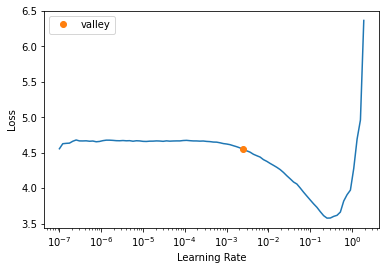

In [8]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,4.398680,4.293971,0.117318,00:01


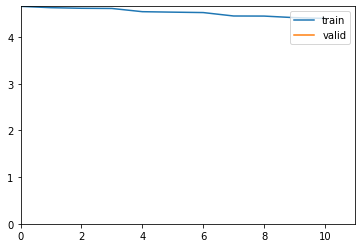

In [9]:
learn.fit_one_cycle(1, 2.5e-3,cbs=[ShowGraphCallback()])

SuggestedLRs(valley=tensor(0.0044))

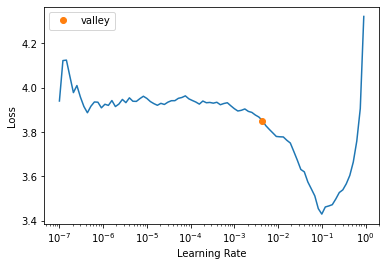

In [10]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,3.861849,3.568621,0.441341,00:01


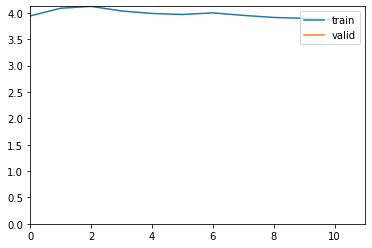

In [12]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, 4.4e-3, cbs=[ShowGraphCallback()])

SuggestedLRs(valley=tensor(0.0030))

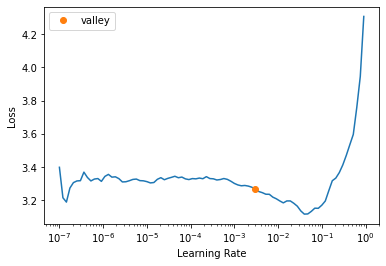

In [13]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,3.265877,3.056587,0.603352,00:01


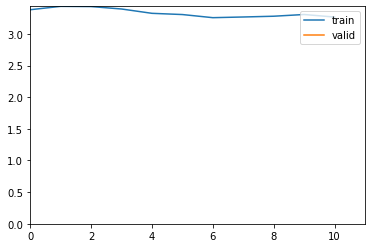

In [14]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, 3e-3,cbs=[ShowGraphCallback()])

SuggestedLRs(valley=tensor(0.0021))

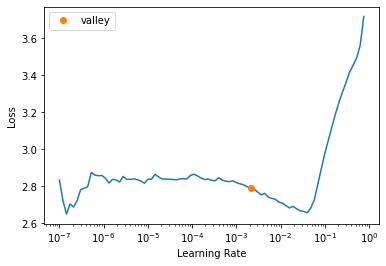

In [15]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,2.797637,2.775678,0.709497,00:01
1,2.655306,2.083513,0.849162,00:01
2,2.419356,1.465209,0.893855,00:01
3,2.137302,1.056879,0.932961,00:01
4,1.854079,0.813998,0.969274,00:01
5,1.593783,0.704908,0.963687,00:01
6,1.367382,0.644261,0.972067,00:01
7,1.182615,0.591455,0.972067,00:01
8,1.037748,0.583284,0.969274,00:01
9,0.928496,0.590684,0.969274,00:01


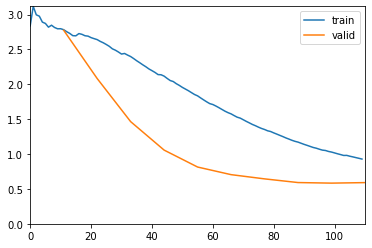

In [16]:
learn.unfreeze()
learn.fit_one_cycle(10, 2.1e-3, cbs=[ShowGraphCallback()])

SuggestedLRs(valley=tensor(0.0017))

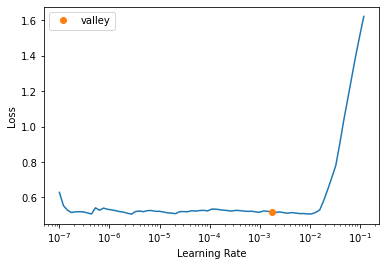

In [17]:
learn.lr_find()

In [18]:
learn.export('models/tc_30.pkl')

epoch,train_loss,valid_loss,accuracy,time
0,0.529656,0.578794,0.966480,00:01
1,0.502250,0.471571,0.969274,00:01
2,0.461235,0.372591,0.969274,00:01
3,0.410270,0.323309,0.974860,00:01
4,0.361484,0.293114,0.969274,00:01
5,0.318966,0.275410,0.966480,00:01
6,0.284176,0.263049,0.972067,00:01
7,0.251409,0.257824,0.972067,00:01
8,0.226594,0.256947,0.974860,00:01
9,0.207944,0.257716,0.972067,00:01


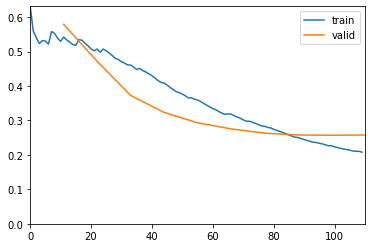

In [19]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1.7e-3/(2.6**4),1.7e-3),cbs=[ShowGraphCallback()])

SuggestedLRs(valley=tensor(0.0010))

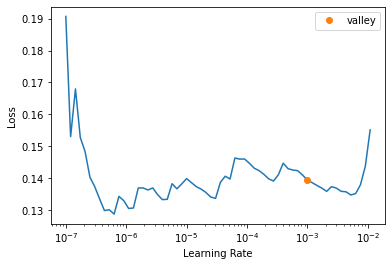

In [20]:
learn.lr_find()

The LR finding has lost its form, so stop here.
Now let's try this trained model

In [33]:
learn.predict('did the covid pandemic make you realize anything about yourself that you didnt already know')

('116',
 tensor(51),
 tensor([2.2524e-04, 2.4586e-03, 5.9059e-04, 5.4570e-04, 1.3344e-03, 2.7431e-04,
         9.6223e-05, 1.1548e-03, 1.1695e-04, 4.4382e-04, 4.4698e-04, 3.6585e-04,
         4.6750e-04, 1.0228e-03, 2.0881e-03, 1.1647e-03, 4.6183e-05, 4.1686e-04,
         2.5658e-04, 5.2017e-04, 8.6310e-04, 5.8623e-04, 1.7652e-04, 2.8278e-04,
         3.9211e-04, 6.2271e-04, 4.2516e-04, 1.4339e-04, 4.1032e-04, 1.5860e-04,
         4.7571e-03, 2.3741e-04, 1.0030e-04, 1.7442e-03, 7.1700e-05, 2.1436e-04,
         8.5492e-04, 1.1542e-03, 4.0946e-04, 4.4894e-04, 1.9879e-03, 4.4923e-04,
         3.2827e-04, 9.9009e-04, 4.4145e-04, 1.6575e-03, 1.4496e-03, 9.0590e-04,
         1.7902e-03, 6.0291e-03, 8.2247e-04, 9.3460e-01, 3.0755e-04, 6.1989e-04,
         3.8364e-04, 2.8326e-04, 2.7084e-04, 4.8068e-04, 6.5596e-05, 5.3440e-04,
         1.3036e-04, 5.6532e-05, 2.0218e-04, 2.1324e-04, 4.8953e-04, 3.4227e-04,
         2.4137e-03, 6.0714e-04, 3.5850e-05, 1.8456e-04, 4.2116e-04, 7.7562e-04,
       

### 2.2 Train the model for categories with less than 65 sampling data but more than 30

In [36]:
# Now let's create the learner
del(learn)
learn = text_classifier_learner(dataloaders[1], AWD_LSTM, drop_mult=0.5, 
                                metrics=accuracy).to_fp16()

learn = learn.load_encoder('lm_10epoch-os-encoder')
dataloaders[1].show_batch(max_n=3)

,text,category
0,xxbos can i catch thhe computer virus orm being in an enclosed space in close xxunk od proximity to someone world healt organization does nt hare respiratory symptoms,182
1,xxbos bum i xxunk the computer virtus from xxmaj boeing lin an xxunk space in xxunk law fo proximity to sameone who does nt have respiratory symptoms,182
2,xxbos what happens if lockdown can prevend from covid for an whole twelvemonth especially that in f respect be n ' ° vaccinum ann cure,109


SuggestedLRs(valley=tensor(0.0025))

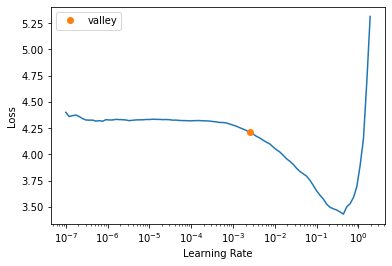

In [37]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,3.739946,3.404997,0.401389,00:01


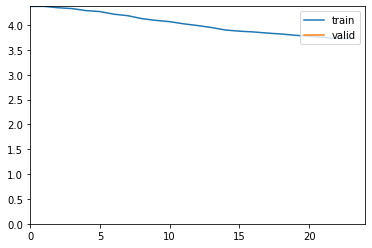

In [38]:
learn.fit_one_cycle(1, 2.5e-3, cbs= [ShowGraphCallback()])

SuggestedLRs(valley=tensor(0.0076))

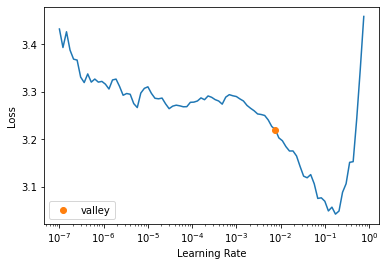

In [39]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,2.952919,1.942324,0.611111,00:01


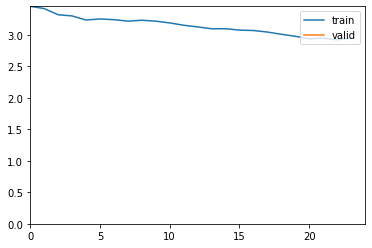

In [40]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, 7.6e-3, cbs=[ShowGraphCallback()])

SuggestedLRs(valley=tensor(0.0021))

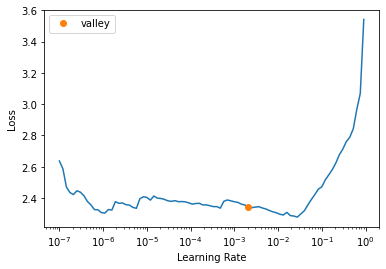

In [41]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,2.159958,1.447650,0.797222,00:01


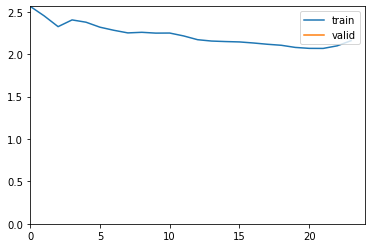

In [42]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, 2.1e-3, cbs=[ShowGraphCallback()])

SuggestedLRs(valley=tensor(0.0014))

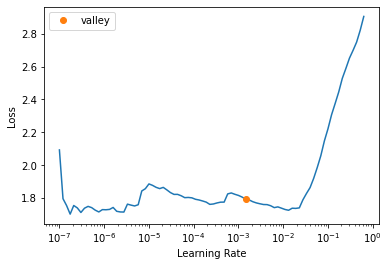

In [43]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,1.791682,1.237847,0.840278,00:01
1,1.605360,0.838897,0.929167,00:01
2,1.335380,0.513512,0.966667,00:01
3,1.027313,0.296585,0.980556,00:01
4,0.760746,0.191358,0.986111,00:01
5,0.562508,0.170686,0.984722,00:01
6,0.419454,0.136045,0.986111,00:01
7,0.320115,0.125353,0.986111,00:01
8,0.252403,0.122357,0.987500,00:01
9,0.209710,0.117881,0.987500,00:01


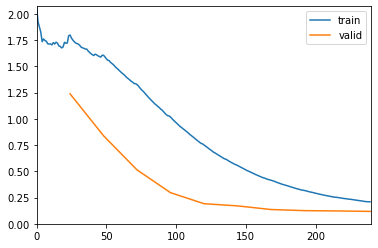

In [44]:
learn.unfreeze()
learn.fit_one_cycle(10, 1.4e-3, cbs=[ShowGraphCallback()])

SuggestedLRs(valley=tensor(0.0005))

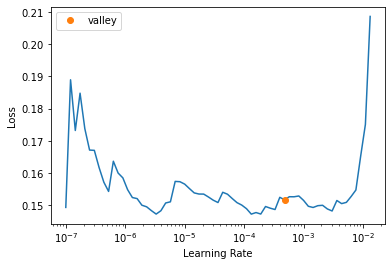

In [45]:
learn.lr_find()

In [46]:
learn.export('models/tc_30_65.pkl')

### 2.3 Train the model for categories with less than 81 sampling data but more than 65

In [47]:
# Now let's create the learner
del(learn)
learn = text_classifier_learner(dataloaders[2], AWD_LSTM, drop_mult=0.5, 
                                metrics=accuracy).to_fp16()

learn = learn.load_encoder('lm_10epoch-os-encoder')
dataloaders[2].show_batch(max_n=3)

,text,category
0,xxbos wath are xxunk imperssion about pretendant of the united states xxunk claiming xxmaj hi was being sarcastic when musing whether people sould inject antimicrobic to kill covid,140
1,xxbos take out pretendant donald trump as at xxunk what person beaver state organization is virtually responsible fo the xxunk cattle ranch of tyhe covid virtus pandemic,115
2,xxbos what are peoples xxunk xxunk xxunk executive cornet claiming he war being sarcastic when musing wheter xxunk should but in disinfectant to voto uot covid,140


SuggestedLRs(valley=tensor(0.0025))

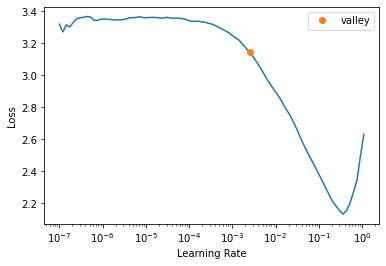

In [48]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,2.806665,2.716844,0.566092,00:01


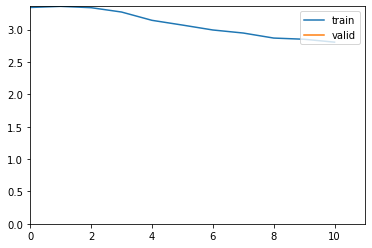

In [49]:
learn.fit_one_cycle(1, 2.5e-3, cbs=[ShowGraphCallback()])

SuggestedLRs(valley=tensor(0.0036))

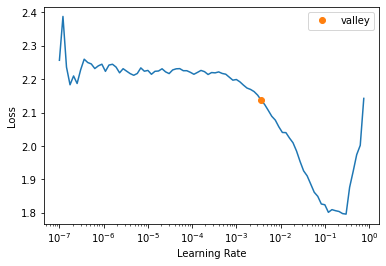

In [50]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,1.992211,1.601029,0.827586,00:01


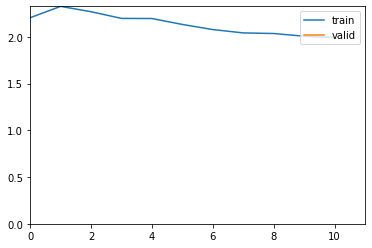

In [51]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, 3.6e-3, cbs=[ShowGraphCallback()])

SuggestedLRs(valley=tensor(0.0014))

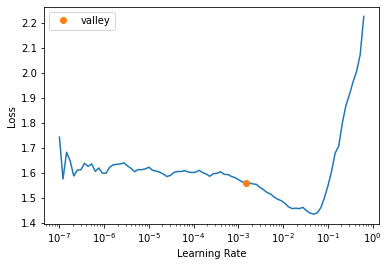

In [52]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,1.544625,1.098148,0.910920,00:01


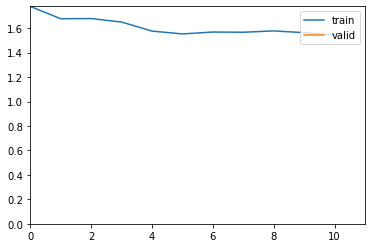

In [53]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, 1.4e-3, cbs=[ShowGraphCallback()])

SuggestedLRs(valley=tensor(0.0010))

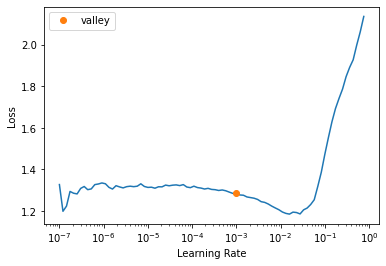

In [54]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,1.311761,0.958361,0.928161,00:01
1,1.263839,0.740430,0.928161,00:01
2,1.181446,0.563954,0.933908,00:01
3,1.085014,0.463292,0.948276,00:01
4,0.990057,0.398399,0.962644,00:01
5,0.902028,0.348719,0.968391,00:01
6,0.826971,0.331168,0.977012,00:01
7,0.771048,0.312495,0.971264,00:01
8,0.718945,0.317247,0.977012,00:01
9,0.673134,0.317892,0.977012,00:01


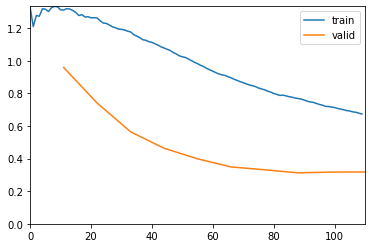

In [55]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-3/(2.6**4),1e-3), cbs=[ShowGraphCallback()])

SuggestedLRs(valley=tensor(0.0010))

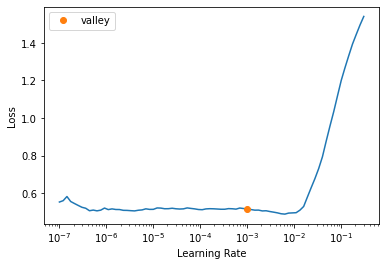

In [56]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,0.513166,0.290721,0.971264,00:01
1,0.504391,0.251912,0.968391,00:01
2,0.463277,0.206887,0.968391,00:01
3,0.423222,0.190859,0.977012,00:01
4,0.391893,0.192150,0.979885,00:01


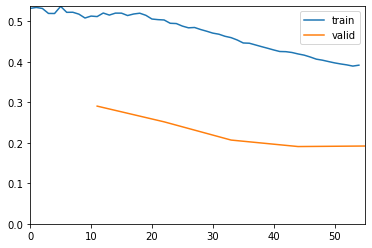

In [57]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3), cbs=[ShowGraphCallback()])

SuggestedLRs(valley=tensor(0.0008))

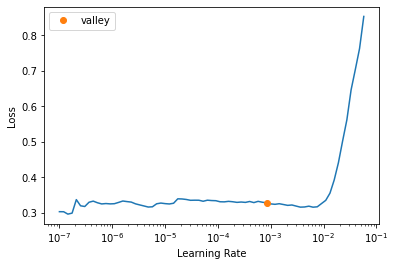

In [58]:
learn.lr_find()

In [59]:
learn.export('models/tc_65_81.pkl')

epoch,train_loss,valid_loss,accuracy,time
0,0.329753,0.187558,0.977012,00:01
1,0.312385,0.169071,0.977012,00:01
2,0.305518,0.151449,0.977012,00:01
3,0.282612,0.126985,0.977012,00:01
4,0.261835,0.122321,0.977012,00:01
5,0.238404,0.113814,0.977012,00:01
6,0.221110,0.107138,0.982759,00:01
7,0.203443,0.102994,0.985632,00:01
8,0.191259,0.099449,0.988506,00:01
9,0.180279,0.100050,0.985632,00:01


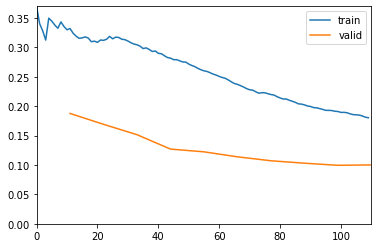

In [60]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(8e-4/(2.6**4),8e-4), cbs=[ShowGraphCallback()])

SuggestedLRs(valley=tensor(0.0003))

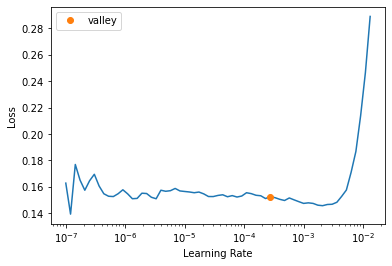

In [61]:
learn.lr_find()

In [62]:
learn.export('models/tc_65_81-9856.pkl')

epoch,train_loss,valid_loss,accuracy,time
0,0.148358,0.100445,0.988506,00:01
1,0.147411,0.096863,0.985632,00:01
2,0.141858,0.090628,0.985632,00:01
3,0.136264,0.087010,0.988506,00:01
4,0.134028,0.084801,0.988506,00:01
5,0.129610,0.083474,0.988506,00:01
6,0.122318,0.082084,0.988506,00:01
7,0.120222,0.078799,0.988506,00:01
8,0.115521,0.078114,0.988506,00:01
9,0.112299,0.079111,0.985632,00:01


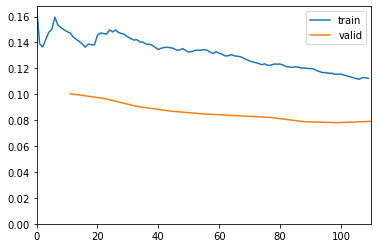

In [63]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(3e-4/(2.6**4),3e-4), cbs=[ShowGraphCallback()])

We can see that the accuracy stops improving, so I stopped here without saving this trained model.

### 2.4 Train the model for categories with less than 100 sampling data but more than 81

In [64]:
# Now let's create the learner
del(learn)
learn = text_classifier_learner(dataloaders[3], AWD_LSTM, drop_mult=0.5, 
                                metrics=accuracy).to_fp16()

learn = learn.load_encoder('lm_10epoch-os-encoder')
dataloaders[3].show_batch(max_n=3)

,text,category
0,xxbos what are the virtually crucial things i n xxrep 3 e d the know to xxunk miself and xxunk safety when atomic xxunk 53 pop off ty the grocery computer storage during thes pandemic,189
1,xxbos what are the most xxunk things i need wuith xxunk in the xxunk ou keep myself and another 's safe wen 1 run xxup to xxmaj they grocery computer storage durin the pandemic,189
2,xxbos be at that place a risck of a second wave of covid like the xxunk xxunk of thw xxmaj spanish flu xxunk killed morre multitude xxunk to the first xxunk,151


SuggestedLRs(valley=tensor(0.0017))

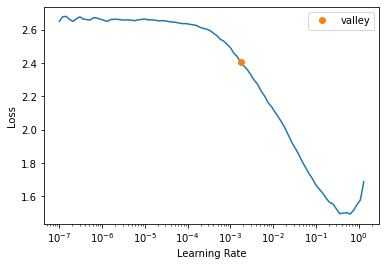

In [66]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,2.294286,2.262544,0.489177,00:01


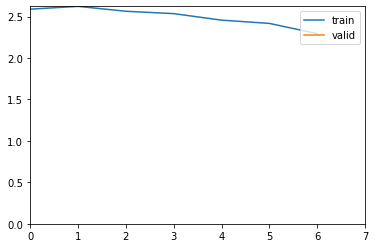

In [67]:
learn.fit_one_cycle(1, 1.7e-3, cbs=[ShowGraphCallback()])

SuggestedLRs(valley=tensor(0.0036))

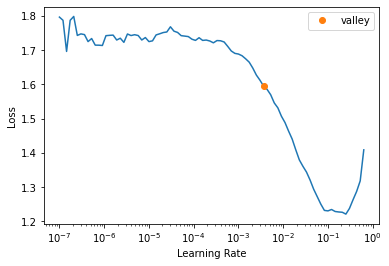

In [68]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,1.561864,1.544677,0.748918,00:01


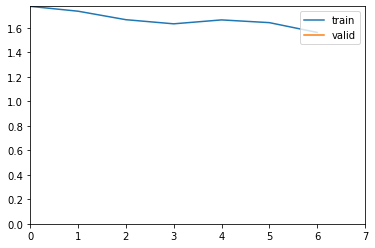

In [69]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, 3.6e-3, cbs=[ShowGraphCallback()])

SuggestedLRs(valley=tensor(0.0017))

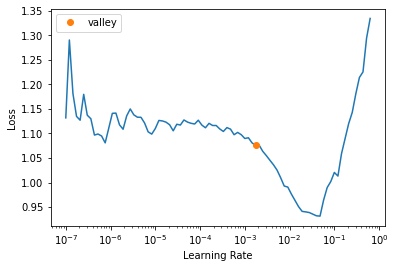

In [70]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,1.059480,1.141645,0.865801,00:01


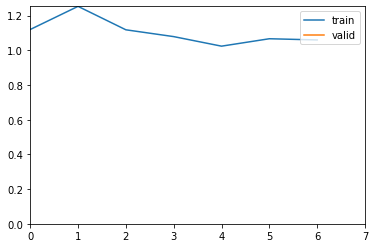

In [71]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, 1.7e-3, cbs=[ShowGraphCallback()])

SuggestedLRs(valley=tensor(0.0010))

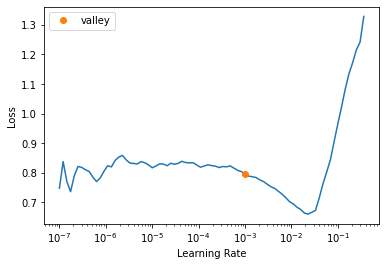

In [72]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,0.837201,0.982904,0.870130,00:01
1,0.820878,0.738263,0.917749,00:01
2,0.750577,0.533701,0.943723,00:01
3,0.684451,0.398246,0.969697,00:01
4,0.624742,0.330862,0.978355,00:01
5,0.570476,0.284919,0.974026,00:01
6,0.526919,0.262049,0.982684,00:01
7,0.487367,0.260046,0.982684,00:01
8,0.458900,0.261068,0.978355,00:01
9,0.432029,0.261898,0.978355,00:01


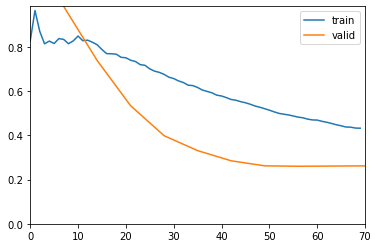

In [73]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-3/(2.6**4),1e-3), cbs=[ShowGraphCallback()])

SuggestedLRs(valley=tensor(0.0012))

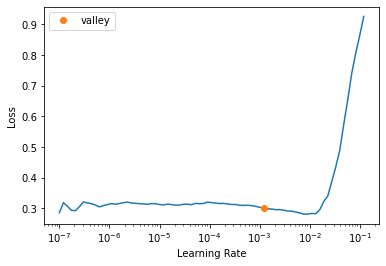

In [74]:
learn.lr_find()

In [75]:
learn.export('models/tc_81_100.pkl')

### 2.5 Train the model for categories with less than 130 sampling data but more than 100

In [76]:
# Now let's create the learner
del(learn)
learn = text_classifier_learner(dataloaders[4], AWD_LSTM, drop_mult=0.5, 
                                metrics=accuracy).to_fp16()

learn = learn.load_encoder('lm_10epoch-os-encoder')
dataloaders[4].show_batch(max_n=3)

,text,category
0,xxbos [ [ wath it 's [ [ th effect xxup ok chloroquine ( cq ) e plaquenil ( hcq ) on endosomal xxunk ann endocytosis in covid intervention,198
1,xxbos [ [ ar food xxunk produced in xxmaj athe joined steates ror other countries affected xxmaj bye . covid a hazard for the spread f covid,180
2,xxbos are food fur [ [ xxunk products xxunk in the united states or former xxunk affected x covid al risk for the facing pages od covid,180


SuggestedLRs(valley=tensor(0.0014))

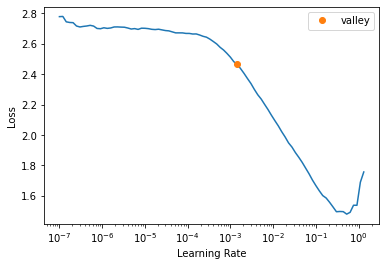

In [77]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,2.307027,2.163682,0.505976,00:01


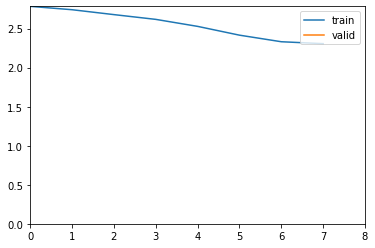

In [78]:
learn.fit_one_cycle(1, 1.4e-3, cbs=[ShowGraphCallback()])

SuggestedLRs(valley=tensor(0.0021))

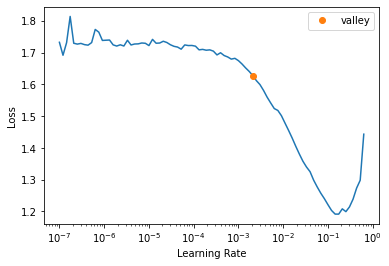

In [79]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,1.509329,1.463922,0.860558,00:01


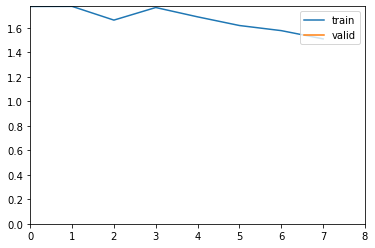

In [80]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, 2.1e-3, cbs=[ShowGraphCallback()])

SuggestedLRs(valley=tensor(0.0014))

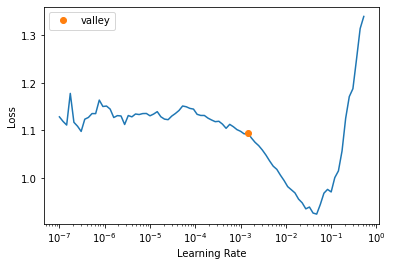

In [81]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,1.062786,0.883173,0.924303,00:01


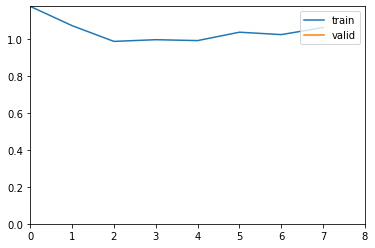

In [82]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, 1.4e-3, cbs=[ShowGraphCallback()])

SuggestedLRs(valley=tensor(0.0012))

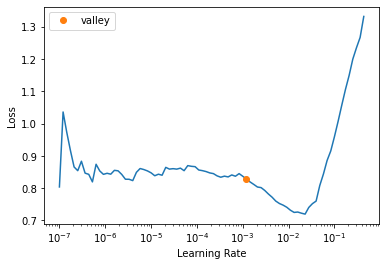

In [83]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,0.849480,0.719322,0.940239,00:01
1,0.806837,0.478705,0.956175,00:01
2,0.743663,0.302530,0.964144,00:01
3,0.669954,0.218643,0.976096,00:01
4,0.598094,0.179897,0.976096,00:01
5,0.540839,0.165200,0.964144,00:01
6,0.487165,0.154994,0.980080,00:01
7,0.449888,0.142032,0.980080,00:01
8,0.413925,0.140659,0.976096,00:01
9,0.391605,0.140770,0.976096,00:01


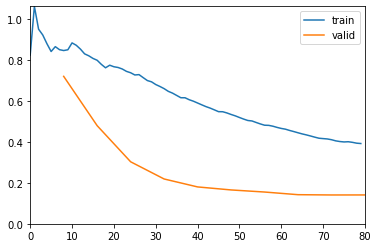

In [84]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1.2e-3/(2.6**4),1.2e-3), cbs=[ShowGraphCallback()])

SuggestedLRs(valley=tensor(0.0004))

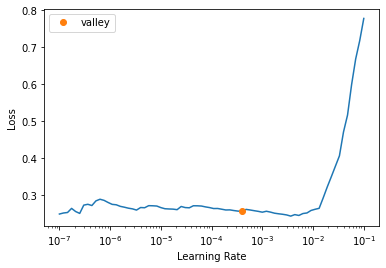

In [85]:
learn.lr_find()

In [86]:
learn.export('models/tc_100_130.pkl')

In [87]:
learn.predict('how did the covid virus appear')

('48',
 tensor(1),
 tensor([0.0069, 0.9450, 0.0036, 0.0021, 0.0045, 0.0135, 0.0035, 0.0034, 0.0129,
         0.0013, 0.0033]))

### 2.6 Train the model for categories with less than 165 sampling data but more than 130

In [131]:
# Now let's create the learner
del(learn)
learn = text_classifier_learner(dataloaders[5], AWD_LSTM, drop_mult=0.5, 
                                metrics=[accuracy, RocAuc()]).to_fp16()

learn = learn.load_encoder('lm_10epoch-os-encoder')
dataloaders[5].show_batch(max_n=3)

,text,category
0,xxbos now come up the transmission rate of covid is n't much higher in the uranium . s. than it ai em china yeat though people ' s republik of china at 's mores compact xxunk populous,141
1,xxbos how ate the infection xxunk of covid xxunk a g xxrep 3 o d deal eminent ni the xxmaj you . s. than it is ni china event xxunk china is more compact and populous,141
2,xxbos the usa have 5 % of th ? hunmer rice population but astir 30 % of covid xxunk xxunk despite being the xxunk nation oon the xxunk where xxmaj dad xxunk techology xxunk wrong,141


SuggestedLRs(valley=tensor(0.0025))

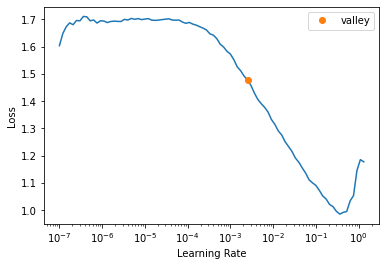

In [132]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,1.490030,1.358987,0.842105,0.971109,00:01


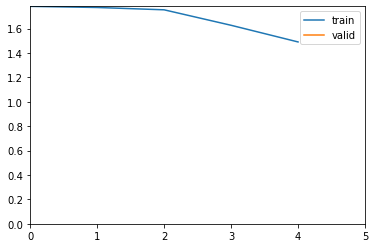

In [133]:
learn.fit_one_cycle(1, 2.5e-3, cbs=[ShowGraphCallback()])

SuggestedLRs(valley=tensor(0.0021))

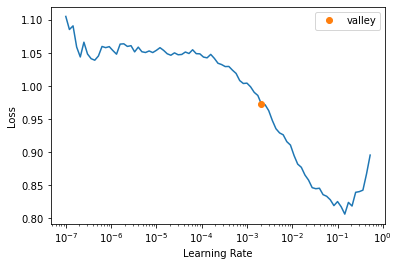

In [134]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.993167,1.014976,0.907895,0.995884,00:01


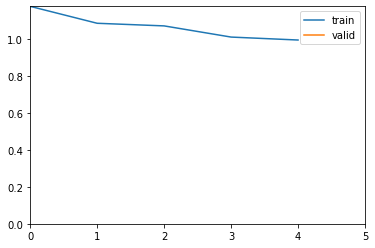

In [135]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, 2.1e-3, cbs=[ShowGraphCallback()])

SuggestedLRs(valley=tensor(0.0014))

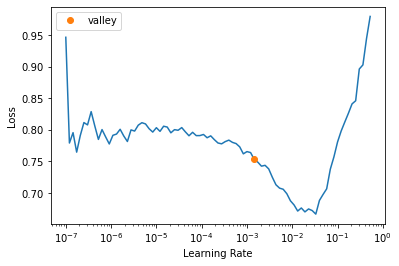

In [136]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.807294,0.718612,0.986842,0.999555,00:01


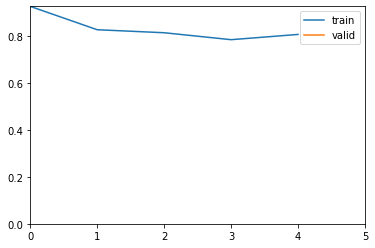

In [137]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, 1.4e-3, cbs=[ShowGraphCallback()])

SuggestedLRs(valley=tensor(0.0010))

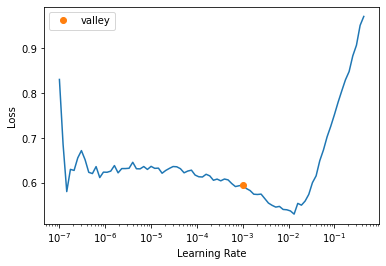

In [138]:
learn.lr_find()

In [139]:
learn.export('models/tc_130-165-9868.pkl')

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.615590,0.499077,0.993421,1.000000,00:01
1,0.567755,0.324913,0.993421,1.000000,00:01
2,0.533399,0.257582,1.000000,1.000000,00:01


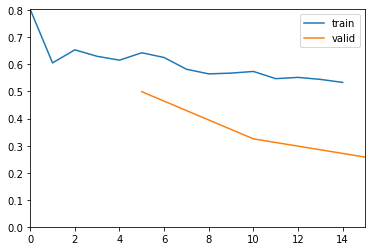

In [140]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3), cbs=[ShowGraphCallback()])

SuggestedLRs(valley=tensor(0.0008))

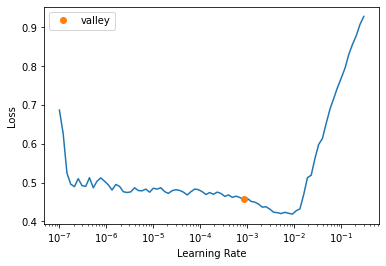

In [141]:
learn.lr_find()

In [142]:
learn.export('models/tc_130_165-100.pkl')

Although I saved the "best model" but I'm gonna to use the 9868 model as the "best model" looks too good to be true.

In [144]:
learn.predict('did covid peak')

('94', tensor(0), tensor([0.7808, 0.0392, 0.0893, 0.0363, 0.0544]))

### 2.7 Train the model for categories with less than 255 sampling data but more than 165

In [145]:
# Now let's create the learner
del(learn)
learn = text_classifier_learner(dataloaders[6], AWD_LSTM, drop_mult=0.5, 
                                metrics=[accuracy, RocAuc()]).to_fp16()

learn = learn.load_encoder('lm_10epoch-os-encoder')
dataloaders[6].show_batch(max_n=3)

,text,category
0,xxbos is xxunk child with an underlying aesculapian condition operating [ [ teather limited healthcare xxunk at xxunk endangerment forward severe ilness from covid,177
1,xxbos xxmaj i 's covid xxunk serious if you fume and do people worl thealth organization vape look the same operating xxunk xxunk risks,177
2,xxbos is my children with ana xxunk medical condition operating theater special healt carry nedd at higher risc for severe unwellness from covid,177


SuggestedLRs(valley=tensor(0.0014))

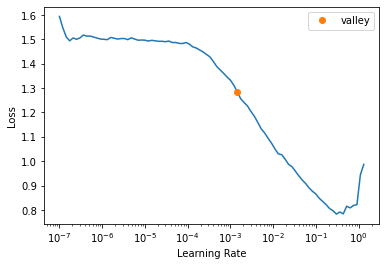

In [147]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,1.190045,1.119577,0.895604,0.976983,00:01


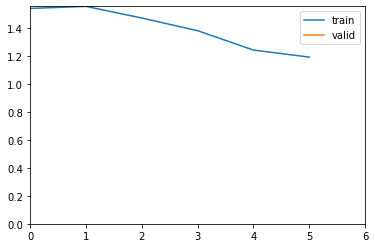

In [148]:
learn.fit_one_cycle(1, 1.4e-3, cbs= [ShowGraphCallback()])

SuggestedLRs(valley=tensor(0.0036))

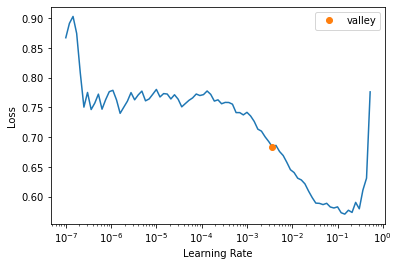

In [149]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.674943,0.459491,0.972527,0.996383,00:01


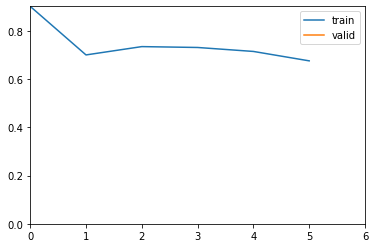

In [150]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, 3.6e-3, cbs= [ShowGraphCallback()])

SuggestedLRs(valley=tensor(0.0030))

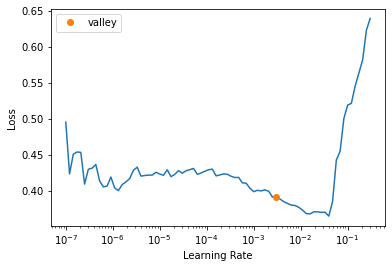

In [151]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.435926,0.288559,0.967033,0.998155,00:01


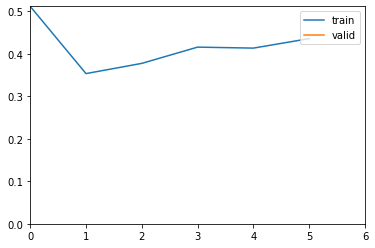

In [152]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(3e-3/(2.6**4),3e-3), cbs= [ShowGraphCallback()])

SuggestedLRs(valley=tensor(0.0010))

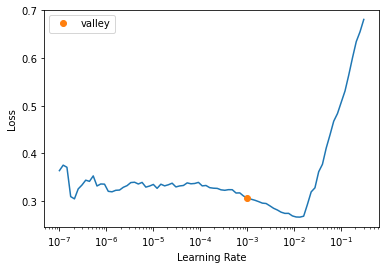

In [153]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.327904,0.230095,0.972527,0.998541,00:01
1,0.318000,0.163867,0.978022,0.998075,00:01
2,0.291219,0.111971,0.978022,0.999655,00:01
3,0.273151,0.087649,0.994505,0.999318,00:01
4,0.249721,0.080606,0.994505,0.998477,00:01
5,0.229297,0.080781,0.983516,0.998622,00:01
6,0.210025,0.081349,0.983516,0.998393,00:01
7,0.196597,0.075791,0.983516,0.998580,00:01
8,0.188711,0.072366,0.983516,0.998697,00:01
9,0.179386,0.073147,0.983516,0.998697,00:01


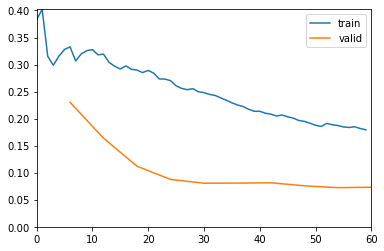

In [154]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-3/(2.6**4),1e-3), cbs= [ShowGraphCallback()])

SuggestedLRs(valley=tensor(0.0010))

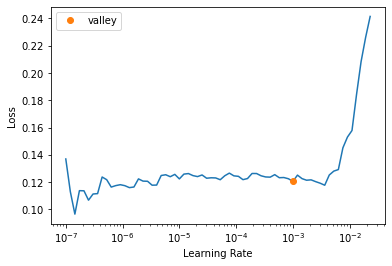

In [155]:
learn.lr_find()

In [156]:
learn.export('models/tc_165_255-9835.pkl')

In [160]:
learn.predict('how does being a smoker impact covid patient outcomes')

('177', tensor(2), tensor([0.0046, 0.0024, 0.9904, 0.0026]))